## ResNet


Inserting the necessary libraries


In [ ]:
# libraries
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

from pathlib import Path
import os
import cv2
import glob
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
import torch
import torchvision.transforms.functional as F
import torch.nn.functional as F
import torch.optim as optim

Loading the pretrained ResNet Model and weights:


In [ ]:
from torchvision.models import resnet18, ResNet18_Weights

# Using pretrained weights:
resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
resnet18(weights="IMAGENET1K_V1")
resnet18(pretrained=True)  # deprecated
resnet18(True)  # deprecated

# Using no weights:
resnet18(weights=None)
resnet18()
resnet18(pretrained=False)  # deprecated
resnet18(False)  # deprecated

# Initialize model
weights = ResNet18_Weights.DEFAULT
model_resnet18 = resnet18(weights=weights)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as

Definiing the training process:



In [ ]:


def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=5, device="cpu"):
    for epoch in range(epochs):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)
        
        model.eval()
        num_correct = 0 
        num_examples = 0
        for batch in val_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.to(device)
            loss = loss_fn(output,targets) 
            valid_loss += loss.data.item() * inputs.size(0)
                        
            correct = torch.eq(torch.max(F.softmax(output, dim=1), dim=1)[1], targets).view(-1)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader.dataset)

        print('Epoch: {}, Training Loss: {:.4f}, Validation Loss: {:.4f}, accuracy = {:.4f}'.format(epoch, training_loss,
        valid_loss, num_correct / num_examples))

Downloading the dataset:





In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/659 Project/train_SOaYf6m/train.csv')
test_df = pd.read_csv('//content/drive/MyDrive/659 Project/test_vc2kHdQ.csv')
data_folder = Path("/content/drive/MyDrive/659 Project/train_SOaYf6m")
data_path = "/content/drive/MyDrive/659 Project/train_SOaYf6m/images/"

path = os.path.join(data_path , "*jpg")
files = glob.glob(path)
data=[]
for file in files:
    image = cv2.imread(file)
    data.append(image)
class EmergencyDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.root_dir = root_dir
        
    def __len__(self):
        return len(self.df)    
    
    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_id, img_label = row['image_names'], row['emergency_or_not']
        img_fname = self.root_dir + str(img_id)
#         + ".jpg"
        img = Image.open(img_fname)
        if self.transform:
            img = self.transform(img)
        return img, img_label


        

Normalizing the dataset:


In [ ]:
batch_size=32
img_dimensions = 224

img_transforms = transforms.Compose([
    transforms.Resize((img_dimensions, img_dimensions)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225] )
    ])

img_test_transforms = transforms.Compose([
    transforms.Resize((img_dimensions,img_dimensions)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225] )
    ])

def check_image(path):
    try:
        im = Image.open(path)
        return True
    except:
        return False


TRAIN_CSV = '/content/drive/MyDrive/659 Project/train_SOaYf6m/train.csv'
transform = transforms.Compose([
    transforms.Resize((img_dimensions, img_dimensions)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225] )
    ])
dataset = EmergencyDataset(TRAIN_CSV, data_path, transform=transform)

Dividing the dataset into training and validation:

In [ ]:
torch.manual_seed(10)

val_pct = 0.2
val_size = int(val_pct * len(dataset))
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(1317, 329)

Defining the validation process through validation function 

In [ ]:
batch_size = 32
def show_batch(dl, invert=True):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        data = 1-images if invert else images
        ax.imshow(make_grid(data, nrow=16).permute(1, 2, 0))
        break
train_data_loader  = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
validation_data_loader = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)


TEST_CSV = '/content/drive/MyDrive/659 Project/test_vc2kHdQ.csv'
test_dataset = EmergencyDataset(TEST_CSV, data_path, transform=transform)
test_data_loader = DataLoader(test_dataset, batch_size, num_workers=2, pin_memory=True)

if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

def valid_model(model):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in validation_data_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('correct: {:d}  total: {:d}'.format(correct, total))
    print('accuracy = {:f}'.format(correct / total))



Running the model:

In [ ]:
model_resnet18.to(device)
optimizer = optim.Adam(model_resnet18.parameters(), lr=0.001)
train(model_resnet18, optimizer, torch.nn.CrossEntropyLoss(), train_data_loader, validation_data_loader, epochs=5, device=device)

Epoch: 0, Training Loss: 1.0357, Validation Loss: 0.4004, accuracy = 0.8723
Epoch: 1, Training Loss: 0.2339, Validation Loss: 0.5289, accuracy = 0.8146
Epoch: 2, Training Loss: 0.1716, Validation Loss: 0.3761, accuracy = 0.8541
Epoch: 3, Training Loss: 0.1089, Validation Loss: 0.2884, accuracy = 0.8936
Epoch: 4, Training Loss: 0.1090, Validation Loss: 0.2929, accuracy = 0.9088


In [ ]:
Training_loss= [1.0357, 0.2339, 0.1716,0.1089,0.1090]
Validation_loss=[0.4004, 0.5289, 0.3761,0.2884,0.2929]
Accuracy= [87.23, 81.46, 85.41, 89.36, 90.88]
Validation_accuracy= [60.88, 52.62, 63.95, 68.76, 74.32 ]

Plotting accuracy and loss graphs:

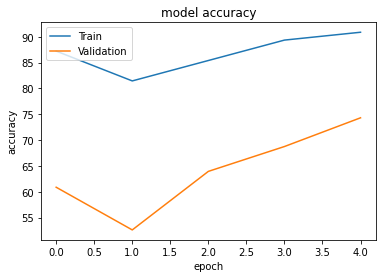

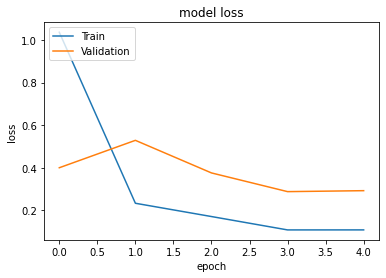

In [ ]:

plt.plot(Accuracy, label='train')
plt.plot( Validation_accuracy, label='validation')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot( Training_loss, label='train')
plt.plot( Validation_loss, label='validation')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## MobileNet

Training the MobileNet model:


In [ ]:
import numpy as np 
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import cv2


import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

train_dir=('/content/drive/MyDrive/659 Project/train_SOaYf6m/images')
df_train=pd.read_csv('/content/drive/MyDrive/659 Project/train_SOaYf6m/train.csv')
df_test=pd.read_csv('/content/drive/MyDrive/659 Project/test_vc2kHdQ.csv')
df_train.head()

df_train['emergency_or_not']=df_train['emergency_or_not'].astype(str)
from keras.preprocessing.image import ImageDataGenerator
datagen=ImageDataGenerator(rescale=1./255)
train_generator=datagen.flow_from_dataframe(dataframe=df_train[:1150], directory=train_dir,x_col='image_names', y_col='emergency_or_not', class_mode='binary',target_size=(224,224),
                                            batch_size=150)
validation_generator=datagen.flow_from_dataframe(dataframe=df_train[1150:], directory=train_dir, x_col='image_names', y_col='emergency_or_not', class_mode='binary', target_size=(224,224), batch_size=150)
mobile_net=MobileNetV2(weights='imagenet', input_shape=(224,224,3), include_top=False)

model=Sequential()
model.add(mobile_net)
model.add(Flatten())
model.add(Dense(120, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(120, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Found 1150 validated image filenames belonging to 2 classes.
Found 496 validated image filenames belonging to 2 classes.
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_1 (Flatten)         (None, 62720)             0         
                                                                 
 dense_3 (Dense)             (None, 120)               7526520   
                                                                 
 dropout_2 (Dropout)         (None, 120)               0         
                                                                 
 dense_4 (Dense)             (None, 120)               14520     
                                                                 

Compiling and running the model:



In [ ]:
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

history1 = model.fit_generator(train_generator,epochs = 5,validation_data = validation_generator)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/5
8/8 [==============================] - 252s 29s/step - loss: 3.0964 - accuracy: 0.6374 - val_loss: 1.1323 - val_accuracy: 0.7782
Epoch 2/5
8/8 [==============================] - 235s 30s/step - loss: 0.2842 - accuracy: 0.8870 - val_loss: 21.0933 - val_accuracy: 0.6089
Epoch 3/5
8/8 [==============================] - 241s 30s/step - loss: 0.1233 - accuracy: 0.9487 - val_loss: 34.1109 - val_accuracy: 0.6069
Epoch 4/5
8/8 [==============================] - 227s 28s/step - loss: 0.0511 - accuracy: 0.9835 - val_loss: 38.5091 - val_accuracy: 0.6069
Epoch 5/5
8/8 [==============================] - 228s 29s/step - loss: 0.0290 - accuracy: 0.9904 - val_loss: 39.3865 - val_accuracy: 0.6069


Plottong the accuracy and loss curves

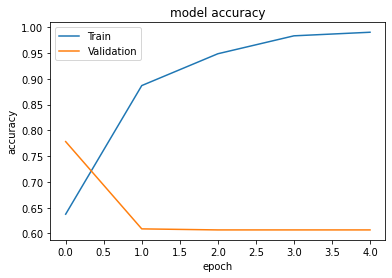

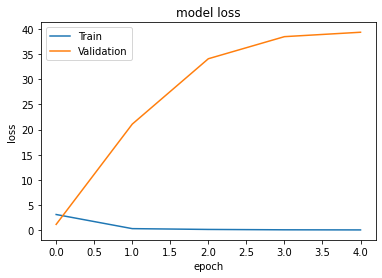

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## VGG16

Importing the VGG16 model:

In [ ]:

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
import matplotlib.pyplot as plt


# importing the vgg16 model from keras
from keras.applications.vgg16 import VGG16
# loading the model 
model = VGG16()


Reshaping the images:

The image is of pickup with probability 65.45302271842957%


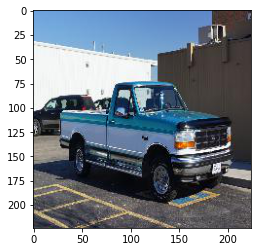

In [ ]:
# Pretrained model as a direct classifier
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
import matplotlib.pyplot as plt



# load an image from file
image = load_img('/content/drive/MyDrive/659 Project/train_SOaYf6m/images/1010.jpg', target_size = (224,224))
img = image
plt.imshow(img)
# convert image to numpy array
image = img_to_array(image)

# reshape the image
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

# preprocess the data for VGG Model (like pixel scaling)
image = preprocess_input(image)

# loading the model
model = VGG16()

# predict the probabilities across all output classes
y_predict = model.predict(image)

# converting probabilities to class labels
y_predict = decode_predictions(y_predict)

# predicting the class label with highest probability
y_predict = y_predict[0][0]

# printing the label
print('The image is of {} with probability {}%'.format(y_predict[1], y_predict[2]*100))


Preparing the training, validation and test set

In [ ]:


# Preparing the training data and validation data sets

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

data = pd.read_csv('/content/drive/MyDrive/659 Project/train_SOaYf6m/train.csv', dtype = str)
train_df = data
# train_df["emergency_or_not"] = train_df["emergency_or_not"].replace({0: 'not_emergency', 1: 'emergency'})
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip = True,
    validation_split = 0.2)
training_set = train_datagen.flow_from_dataframe(
    train_df, 
    "/content/drive/MyDrive/659 Project/train_SOaYf6m/images", 
    x_col='image_names',
    y_col='emergency_or_not',
    target_size= (224,224),
    class_mode='categorical',
    shuffle = True,
    batch_size = 32,
    subset = 'training')

validation_set = train_datagen.flow_from_dataframe(
    train_df, 
    "/content/drive/MyDrive/659 Project/train_SOaYf6m/images", 
    x_col='image_names',
    y_col='emergency_or_not',
    target_size= (224,224),
    class_mode='categorical',
    shuffle = True,
    batch_size = 32,
    subset = 'validation')

# Preparing test data
test_data = pd.read_csv('/content/drive/MyDrive/659 Project/test_vc2kHdQ.csv')
test_df = test_data
test_datagen = ImageDataGenerator(rescale=1./255)

test_set = test_datagen.flow_from_dataframe(
        test_df,
        '/content/drive/MyDrive/659 Project/test_vc2kHdQ.csv',
        x_col = 'image_names',
        y_col = None,
        target_size=(224,224),
        batch_size=32,
        shuffle = False,
        class_mode = None)

Found 1317 validated image filenames belonging to 2 classes.
Found 329 validated image filenames belonging to 2 classes.
Found 0 validated image filenames.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 706 invalid image filename(s) in x_col="image_names". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Defining the model

In [ ]:
# Loading the VGG-16, with pre trained weights
# The fully connected layers are removed 
model = VGG16(include_top = False, weights = 'imagenet', input_shape = (224,224,3))
# Existing layers are not trained
for layer in model.layers:
    layer.trainable = False

# Adding more layers to the model
flatten = tf.keras.layers.Flatten()(model.output) #flattening  the last layers in the above model
dense_1 = tf.keras.layers.Dense(units = 200, activation= 'relu')(flatten)
dense_2 = tf.keras.layers.Dense(units = 200, activation= 'relu')(dense_1)
dense_3 = tf.keras.layers.Dense(units = 200, activation= 'relu')(dense_2)

# output layer neurons is kept to 1 since it is binary classification problem
output = tf.keras.layers.Dense(units = 2, activation = 'softmax')(dense_3) 
model  = tf.keras.Model(inputs = model.input, outputs = output)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

Running the model

In [ ]:
#Early stopping to get opimal epochs
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

ES = EarlyStopping(monitor = 'val_accuracy', mode = 'max', verbose = 1, patience = 4)
#MC = ModelCheckpoint('best_model.h5', monitor = 'val_accuracy')

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = model.fit(x = training_set, validation_data = validation_set, epochs = 3)

Epoch 1/3
42/42 [==============================] - 869s 21s/step - loss: 0.7650 - accuracy: 0.6743 - val_loss: 0.3273 - val_accuracy: 0.8571
Epoch 2/3
42/42 [==============================] - 867s 21s/step - loss: 0.3643 - accuracy: 0.8459 - val_loss: 0.4348 - val_accuracy: 0.8024
Epoch 3/3
42/42 [==============================] - 863s 21s/step - loss: 0.2840 - accuracy: 0.8808 - val_loss: 0.4696 - val_accuracy: 0.8024


Plotting the curves

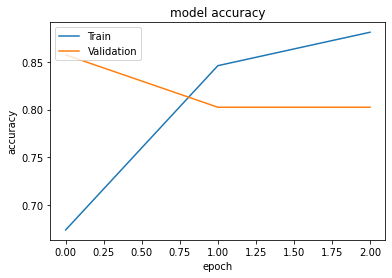

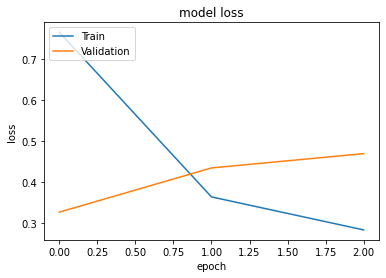

In [ ]:




import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Sending the alert message through email based on classification:

In [ ]:
#Importing libraries for sending email notification
import smtplib, ssl
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart

sender_email = "project6592022@gmail.com" #Default Sender email created
receiver_email = 'batrasushant612@gmail.com'#Default receiver email id given to receive the alert for the emergency vehicle notification
password = "prceewuerpbshxrp" #Password for the sender email id

email_message = MIMEMultipart("alternative")
email_message["Subject"] = "EMERGENCY VEHICLE ALERT !" #Subject of the email
email_message["From"] = sender_email
email_message["To"] = receiver_email

# Body of the mail in plain text and HTML format
text = """\
Emergency vehicle is approaching and demands that drivers give way as soon as possible !"""
html = """\
<html>
  <body>
    <p><b>Emergency vehicle is approaching and demands that drivers give way as soon as possible !</b></p>
  </body>
</html>
"""

# Converting the message into the secure format accepted by the email service
part1 = MIMEText(text, "plain")
part2 = MIMEText(html, "html")

#Attaching the converted text to the mail body
email_message.attach(part1)
email_message.attach(part2)

# Create secure connection with server to send email
def_context = ssl.create_default_context()

with smtplib.SMTP_SSL("smtp.gmail.com", 465, context=def_context) as server:
    server.login(sender_email, password)
    
    print("Connection established with the server.")
    
    server.sendmail(
        sender_email, receiver_email, email_message.as_string()
    )
    print("\nMail Sent to ",receiver_email)

Connection established with the server.

Mail Sent to  batrasushant612@gmail.com


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
X = [1,2,3]

Resnet_train_loss= [1.0357, 0.2339, 0.1716]
Resnet_val_loss= [0.8004, 0.7289, 0.4761]
Resnet_train_acc= [87.23, 81.46, 85.41]
Resnet_val_acc= [60.88, 52.62, 63.95]
mobile_train_loss=[3.09,0.28,0.12]
mobile_val_loss= [1.13, 21.09,34.11]
mobile_train_acc=[63.74,88.7,94.87]
mobile_val_acc= [77.82,60.89,60.69]
vgg_train_loss=[0.76,0.36,0.28]
vgg_val_loss= [0.32,0.43,0.46]
vgg_train_acc=[67.43,84.59,88.08]
vgg_val_acc= [85.71,80.24,80.24]

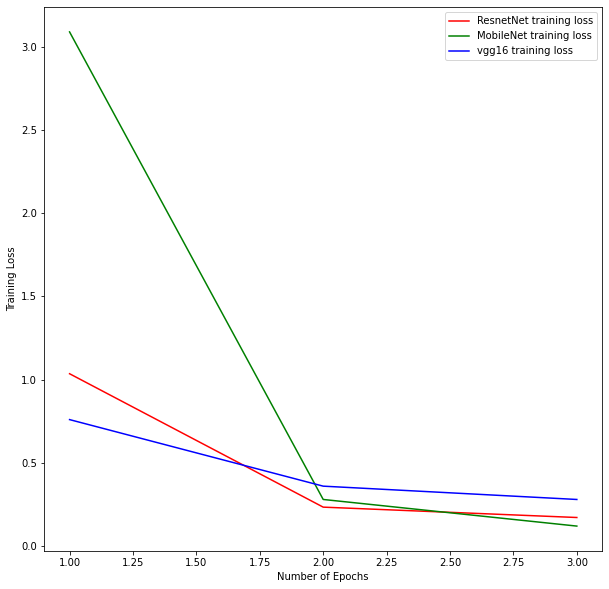

In [ ]:
plt.figure(figsize=(10,10))
X = [1,2,3]
plt.plot(X, Resnet_train_loss, color='r', label='ResnetNet training loss')
plt.plot(X,  mobile_train_loss , color='g', label='MobileNet training loss')
plt.plot(X,  vgg_train_loss, color='b', label='vgg16 training loss')

plt.xlabel("Number of Epochs")
plt.ylabel("Training Loss")

plt.legend(['ResnetNet training loss', 'MobileNet training loss', 'vgg16 training loss'])
plt.show()


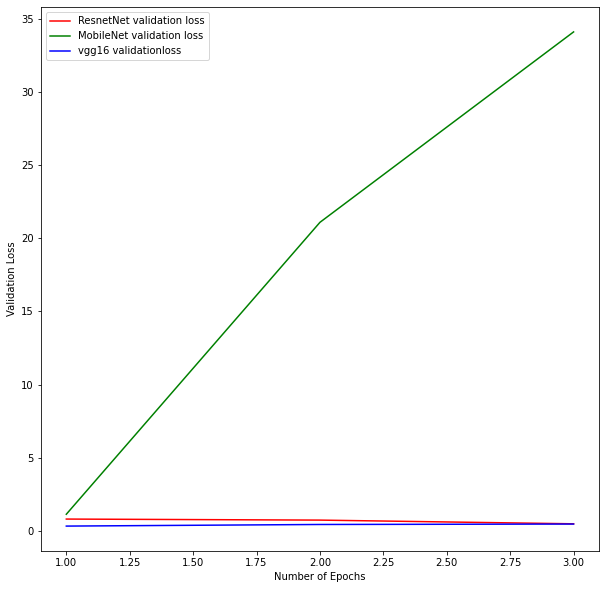

In [ ]:

plt.figure(figsize=(10,10))
X = [1,2,3]
plt.plot(X,  Resnet_val_loss, color='r', label='ResnetNet validation loss')
plt.plot(X,  mobile_val_loss, color='g', label='MobileNet validation loss')
plt.plot(X,  vgg_val_loss, color='b', label='vgg16 validation loss')

plt.xlabel("Number of Epochs")
plt.ylabel("Validation Loss")

plt.legend(['ResnetNet validation loss', 'MobileNet validation loss', 'vgg16 validationloss'])
plt.show()


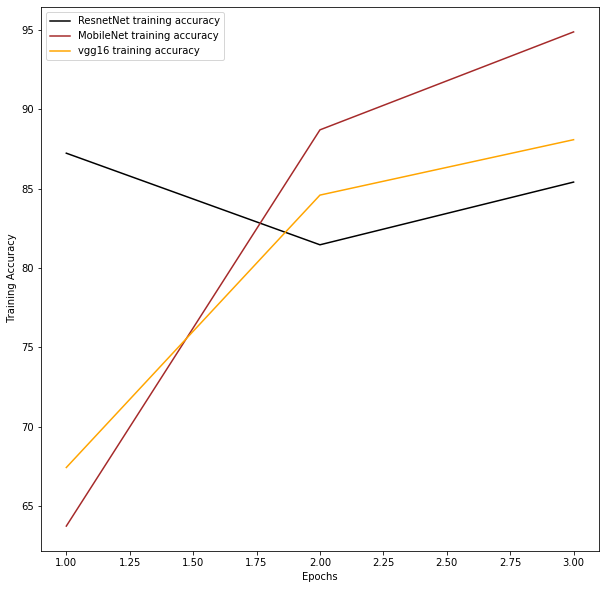

In [ ]:
plt.figure(figsize=(10,10))
X = [1,2,3]
plt.plot(X, Resnet_train_acc, color='black', label='ResnetNet training accuracy')
plt.plot(X,  mobile_train_acc , color='brown', label='MobileNet training accuracy')
plt.plot(X,  vgg_train_acc, color='orange', label='vgg16 training accuracy')

plt.xlabel("Epochs")
plt.ylabel(" Training Accuracy")

plt.legend(['ResnetNet training accuracy', 'MobileNet training accuracy', 'vgg16 training accuracy'])
plt.show()


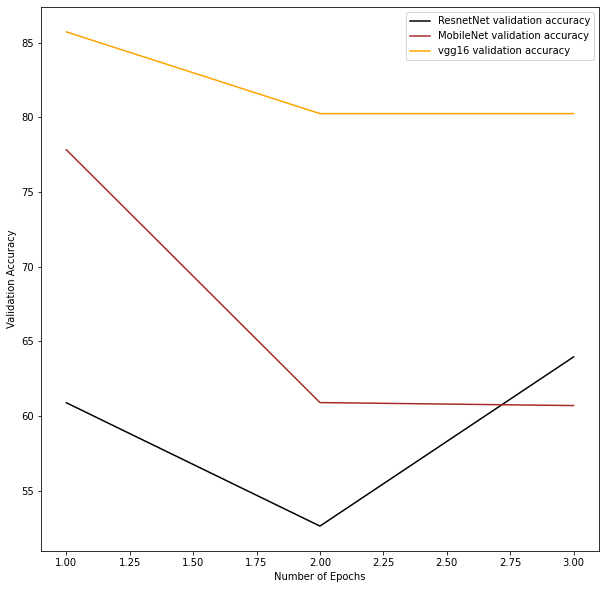

In [ ]:
plt.figure(figsize=(10,10))
X = [1,2,3]
plt.plot(X,  Resnet_val_acc, color='black', label='ResnetNet validation accuracy')
plt.plot(X,  mobile_val_acc, color='brown', label='MobileNet validation accuracy')
plt.plot(X,  vgg_val_acc, color='orange', label='vgg16 validation accuracy')

plt.xlabel("Number of Epochs")
plt.ylabel("Validation Accuracy")

plt.legend(['ResnetNet validation accuracy', 'MobileNet validation accuracy', 'vgg16 validation accuracy'])
plt.show()